# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    avg_precision = 0
    for j in range(len(relevant)):
        avg_prec = 0
        for i in range(k):

            prec = len(list(set(relevant[j]) & set(predicted[j][:i+1]))) / (i + 1)
            avg_prec += prec * int(((predicted[j][i] in relevant[j]) == True))

        n_u = len(relevant[j])
        avg_precision += avg_prec / min(k, n_u)
    MAP = avg_precision / len(relevant)
    return MAP

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
len(np.unique(ratings['userId']))

241

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            test_preds += [self.recommend(user_id)]

        test_preds = self.remove_train_items(test_preds, k)
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
train_ratings[:10]

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
5,0,432
6,0,470
7,0,490
8,0,491
9,0,559


In [17]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
  jac_list = []
  for i in range(ratings.shape[0]):
      intersection = len(np.where((user_vector * ratings[i, :]) == 1)[0])
      union = len(np.where((user_vector > 0) | (ratings[i, :] > 0))[0])
      jac_list.append(intersection / union)

  return np.array(jac_list)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [18]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similarity = self.similarity_func(self.R, user_vector)
        similarity[(similarity < self.alpha) | (similarity == 1)] = 0
        return similarity
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

    def recommend(self, uid: int):

        similarity = self.similarity(self.R[uid])
        recs = similarity @ self.R
        return np.argsort(-recs)

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [19]:
k_array = np.arange(1, 101)

In [ ]:
def remove_train_items(preds: List[List[int]], k: int):

        new_preds = np.zeros((len(preds), k), dtype=int)
        
        for user_id, user_data in ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

In [20]:
random_recs = np.array(list(np.random.choice(train_ratings['trackId'].unique(), k_array[-1]) for _ in test_users))

random_recs

array([[49348, 43744,  4764, ..., 54401, 59699, 40031],
       [39261, 20935, 48403, ..., 46513, 34678, 37745],
       [58936, 10774, 55278, ..., 21625, 55919, 44923],
       ...,
       [49587, 51338, 32824, ..., 18603, 35752, 38016],
       [41183, 34870, 65010, ..., 44147, 15170,  1627],
       [ 1311, 43596, 38058, ..., 31106,  8958, 39008]])

In [21]:
popular_recs = train_ratings['trackId'].value_counts()[:k_array[-1]].index.tolist()
popular_recs = np.array(popular_recs * test_users[-1]).reshape((test_users[-1], len(popular_recs)))

popular_recs

array([[ 2814,  1073,   805, ..., 14692, 46533,  9691],
       [ 2814,  1073,   805, ..., 14692, 46533,  9691],
       [ 2814,  1073,   805, ..., 14692, 46533,  9691],
       ...,
       [ 2814,  1073,   805, ..., 14692, 46533,  9691],
       [ 2814,  1073,   805, ..., 14692, 46533,  9691],
       [ 2814,  1073,   805, ..., 14692, 46533,  9691]])

In [22]:
jac_recs = User2User(train_ratings).get_test_recommendations(k=k_array[-1])
print(jac_recs)

[[  724  6441  4507 ... 19489  6170   754]
 [ 2814 24500   805 ... 51007 50994 48952]
 [ 1073  2555  1019 ... 27805  5395  2537]
 ...
 [49577  1019 12262 ... 17788 35293  6975]
 [ 4032  8263  1056 ...   474 16231  9385]
 [16856 47222 44185 ... 22735 15872 27978]]


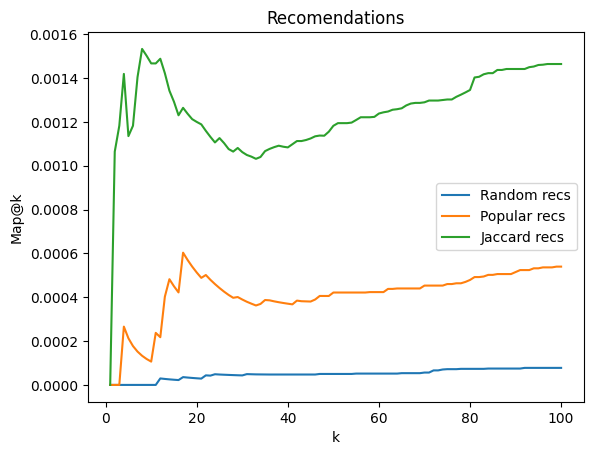

In [ ]:
mapk_rand = list(mapk(test_relevant, random_recs, k) for k in k_array)
mapk_pop = list(mapk(test_relevant, popular_recs, k) for k in k_array)
mapk_jac = list(mapk(test_relevant, jac_recs, k) for k in k_array)

plt.plot(k_array, mapk_rand, label='Random recs')
plt.plot(k_array, mapk_pop, label='Popular recs')
plt.plot(k_array, mapk_jac, label='Jaccard recs')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('Recomendations')
plt.show()

Лучшим оказался способ, использующий метод Жаккара для создания рекомендаций, так как он работает на основе схожести пользователей, что весьма логично. Далее идут реки популярных треков, это менее логично, но объянимо, если популярен трек, то он многим нравится, следовательно высокая вероятность, что и нашему юзеру понравится, однако константные предсказания работают не очень качественно, рандомные ожидаемо очень плохи.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [23]:
n_users = len(np.unique(ratings['userId']))
n_items = len(np.unique(ratings['trackId']))

In [25]:
from scipy.sparse import csr_matrix, find  #find - выводит три array массива с индексом строк, индексом столбцов и значениями ненулевых элементов матрицы

def jaccard_csr(ratings: csr_matrix, user_vector: csr_matrix) -> csr_matrix:
  jac_list = []
  for i in range(ratings.shape[0]):
      intersection = len(np.intersect1d(find(user_vector)[1], find(ratings[i, :])[1]))
      union = len(np.union1d(find(user_vector)[1], find(ratings[i, :])[1]))
      jac_list.append(intersection / union)

  return np.array(jac_list)

class U2U_csr(User2User):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.R = csr_matrix(self.R)
        self.similarity_func = jaccard_csr

In [21]:
u2u = U2U_csr(train_ratings)
jac_csr_recs = u2u.get_test_recommendations(100)

Скорость упала примерно в 3 раза: в первом случае код выдавал рекоммендации за 14 секунд, сейчас выдает за 43 секунды.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
model = U2U_csr(train_ratings)

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
215,Lick It Up,['Kiss']
220,I Was Made For Lovin' You,['Kiss']
411,Don't Cry,"[""Guns N' Roses""]"
445,Fire Water Burn,['Bloodhound Gang']
446,Kiss Me Where It Smells Funny,['Bloodhound Gang']
458,The Rock Show,['blink-182']
461,Online Songs,['blink-182']
462,First Date,['blink-182']
463,Every Time I Look For You,['blink-182']
467,Joker & the Thief,['Wolfmother']


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
7934,Думай,['F.P.G.']
13075,Дождь,['Блондинка КсЮ']
8394,Broken Promises,['Element Eighty']
2345,Basket Case,['Green Day']
21463,Bodies,['Drowning Pool']
16403,Warriors of the World United,['Manowar']
859,The Memory Remains,"['Metallica', 'Marianne Faithfull']"
3217,Rock & Roll Queen,['The Subways']
7533,Highway to Hell,['AC/DC']
1169,Whiskey in the Jar,['Metallica']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
67101,Dad Vibes,['Limp Bizkit']


Видим, что пользователеь слушает в основном рок, панк-рок. В предложке есть AC/DC, Metallica, Green Day. Однако остальные треки по жанру недостаточно точно показывают предпочтения юзера. Надо улучшать

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Ответ

Рассчитываем градиент функции потерь по $p_u$ и $q_i$

$\nabla_{p_u} L = \sum\limits_i 2(p_u^T q_i - r_{ui}) + 2\lambda p_u$

$\nabla_{q_u} L = \sum\limits_u 2p_u(q_i^T p_u - r_{ui}) + 2\lambda q_i$

Используя метод градиентного спуска, обновляем веса векторов, домножая градиент на learning rate.

$p_u^* = p_u - lr*2(q_i q_i^T p_u - r_{ui}q_i + \lambda p_u)$

$q_i^* = q_i - lr*2(p_u p_u^T q_i - r_{ui}p_u + \lambda q_i)$

\\
**ALS:**

Ответ

$\nabla_{p_u} \bigg[ \sum_{u,i} (r_{ui} - \langle p_u, q_i \rangle)^2 \bigg] = \sum_{i} 2(r_{ui} - \langle p_u, q_i \rangle)q_i = 0$

Воспользовавшись тем, что $a^Tbc = cb^Ta$, получим

$\sum_{i} r_{ui}q_i - \sum_i q_i q_i^T p_u = 0$

Тогда окончательно каждый столбец матрицы $P$ можно найти по формуле

$p_u^* = \bigg( \sum_i q_i q_i^T\bigg)^{-1}\sum_ir_{ui}q_i \;\; \forall u$

аналогично для столбцов матрицы $Q$

$q_i^* = \bigg( \sum_u p_u p_u^T\bigg)^{-1}\sum_ur_{ui}p_u \;\; \forall i$

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
from statistics import mean

In [26]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, self.dim))
        self.Q = np.random.normal(size=(self.n_items, self.dim))

        self.lr = 0.003
        self.lamb = 0.05

        self.Loss = []

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd': #обычный SGD
                u = np.random.choice(self.n_users) #так как обучаем векторы, возьмем рандомно их из матрицы
                i = np.random.choice(self.n_items)

                self.P[u] = self.P[u] - 2 * self.lr * (self.P[u] @ self.Q[i] * self.Q[i] - self.R[u][i] * self.Q[i] + self.lamb * self.P[u])
                self.Q[i] = self.Q[i] - 2 * self.lr * (self.P[u] @ self.Q[i] * self.P[u] - self.R[u][i] * self.P[u] + self.lamb * self.Q[i])
                loss = (self.R[u][i] - self.P[u] @ self.Q[i])**2 + self.lamb * (self.Q[i] @ self.Q[i] + self.P[u] @ self.P[u])
                self.Loss.append(float(loss))

            elif self.mode == 'als': #код из семинара по рекам https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/seminars/sem24-recommendations.ipynb
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = self.ratings['trackId'][self.ratings['userId'] == u]
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RQ[u]

                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = self.ratings['userId'][self.ratings['trackId'] == i]
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RP[i]
              
        #print(mean(self.Loss))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
dim_par = [64, 128]
num_iters = [1000000, 5000000, 10000000]
best_sgd_mapk = 0
best_als_mapk = 0


for d in dim_par:
    for iter in num_iters:

        sgd_model = LatentFactorModel(train_ratings, mode='sgd', dim=d)
        sgd_model.fit(iter)
        sgd_recs = sgd_model.get_test_recommendations(100)
        sgd_mapk = mapk(test_relevant, sgd_recs, 15)

        if sgd_mapk > best_sgd_mapk:
            best_sgd_mapk = sgd_mapk
            sgd_iter_best = iter
            sgd_dim_best = d
  
print(f'Best hyperparameters for sgd model: iter={sgd_iter_best}, dim={sgd_dim_best}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

3.623385470156642


  0%|          | 0/5000000 [00:00<?, ?it/s]

3.2153091677374595


  0%|          | 0/10000000 [00:00<?, ?it/s]

3.1055594834997975


  0%|          | 0/1000000 [00:00<?, ?it/s]

6.662967379322643


  0%|          | 0/5000000 [00:00<?, ?it/s]

6.310798387293369


  0%|          | 0/10000000 [00:00<?, ?it/s]

6.149537270617932
Best hyperparameters for sgd model: iter=5000000, dim=128


In [27]:
sgd_model = LatentFactorModel(train_ratings, mode='sgd', dim=32)
sgd_model.fit(10)
sgd_recs = sgd_model.get_test_recommendations(k=k_array[-1])
print(sgd_recs)

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 5471 21732 60542 ... 25343 12036 41833]
 [51583 45871 29923 ... 58022 61482  2390]
 [15899 32087 59911 ...  4561  5066 37354]
 ...
 [27104 35630 36767 ... 23069 33424 41149]
 [63297 63181  6343 ... 59925 19212 14219]
 [54164 11553 10506 ... 34934 56603 24582]]


In [ ]:
dim_par = [32, 64, 128]
num_iters = [iter for iter in range(2, 6, 1)]
best_sgd_mapk = 0
best_als_mapk = 0


for d in dim_par:
    for iter in num_iters:

        als_model = LatentFactorModel(train_ratings, mode='als', dim=d)
        als_model.fit(iter)
        als_recs = als_model.get_test_recommendations(50)
        als_mapk = mapk(test_relevant, als_recs, 15)

        if als_mapk > best_als_mapk:
            best_als_mapk = als_mapk
            als_iter_best = iter
            als_dim_best = d

print(f'Best hyperparameters for als model: iter={als_iter_best}, dim={als_dim_best}')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters for als model: iter=4, dim=64


In [34]:
als_model = LatentFactorModel(train_ratings, mode='als', dim=128)
als_model.fit(4)
als_recs = als_model.get_test_recommendations(k=k_array[-1])
print(als_recs)

  0%|          | 0/4 [00:00<?, ?it/s]

[[37835 39455 27586 ... 52206  6162 39167]
 [20337 11493 53422 ...  7533 29596 55590]
 [11493 24500 27822 ... 38866 50939 25152]
 ...
 [49975 41502 12648 ...  1609 50764 57220]
 [40209 41202 49589 ... 56396 39477 20616]
 [11493  9691  1056 ...  1033 34598 59741]]


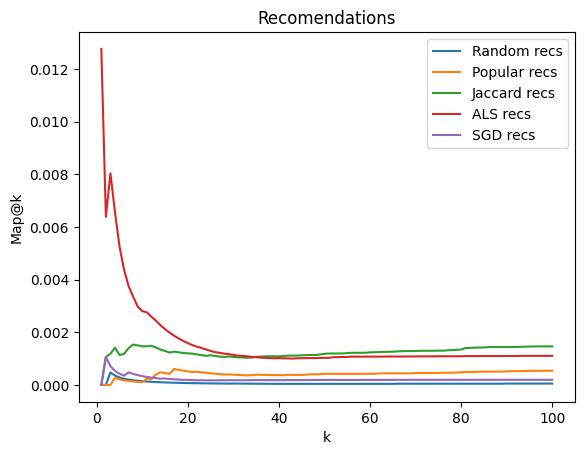

In [35]:
mapk_rand = list(mapk(test_relevant, random_recs, k) for k in k_array)
mapk_pop = list(mapk(test_relevant, popular_recs, k) for k in k_array)
mapk_jac = list(mapk(test_relevant, jac_recs, k) for k in k_array)
mapk_als = list(mapk(test_relevant, als_recs, k) for k in k_array)
mapk_sgd = list(mapk(test_relevant, sgd_recs, k) for k in k_array)

plt.plot(k_array, mapk_rand, label='Random recs')
plt.plot(k_array, mapk_pop, label='Popular recs')
plt.plot(k_array, mapk_jac, label='Jaccard recs')
plt.plot(k_array, mapk_als, label='ALS recs')
plt.plot(k_array, mapk_sgd, label='SGD recs')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.title('Recomendations')
plt.legend()
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [36]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = als_model.Q @ als_model.Q[example_trackId]
preds = preds / np.sqrt((als_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [37]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.671972
2179,Восьмиклассница,['КИНО'],0.586146
10282,Владивосток 2000,['Мумий Тролль'],0.532616
26075,Лошадка,['Найк Борзов'],0.526332
16224,Пока горит свеча,['Машина времени'],0.523533
5153,Stormbringer,['Deep Purple'],0.523175
16637,Zodiac,['Zodiac'],0.523175
9689,Bicycle Race,['Queen'],0.523175
13263,Мусорный ветер,['Крематорий'],0.518919


Все супер, выдает отличные реки с большим симиларити.

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [38]:
class iALS(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, self.dim))
        self.Q = np.random.normal(size=(self.n_items, self.dim))
        self.W = self.R
        self.W[self.W > 0] = 3
        self.W[self.W == 0] = 1


        self.lr = 0.003
        self.lamb = 0.05

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd': #обычный SGD
                u = np.random.choice(self.n_users) #так как обучаем векторы, возьмем рандомно их из матрицы
                i = np.random.choice(self.n_items)

                self.P[u] = self.P[u] - 2 * self.lr * self.W[u][i] * (self.P[u] @ self.Q[i] * self.Q[i] - self.R[u][i] * self.Q[i] + self.lamb * self.P[u])
                self.Q[i] = self.Q[i] - 2 * self.lr * self.W[u][i] * (self.P[u] @ self.Q[i] * self.P[u] - self.R[u][i] * self.P[u] + self.lamb * self.Q[i])

            elif self.mode == 'als':
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim)) @ self.Q.T @ self.W.T).T
                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.dim)) @ self.P.T @ self.W).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [39]:
ials_model_als = iALS(train_ratings, mode='als', dim=64)
ials_model_als.fit(2000)
ials_als_recs = ials_model_als.get_test_recommendations(k=k_array[-1])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [40]:
ials_model_sgd = iALS(train_ratings, mode='sgd', dim=8)
ials_model_sgd.fit(20)
ials_sgd_recs = ials_model_sgd.get_test_recommendations(k=k_array[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

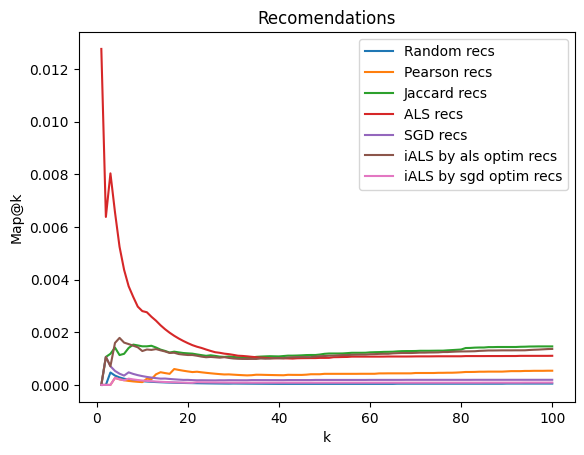

In [41]:
mapk_rand = list(mapk(test_relevant, random_recs, k) for k in k_array)
mapk_pop = list(mapk(test_relevant, popular_recs, k) for k in k_array)
mapk_jac = list(mapk(test_relevant, jac_recs, k) for k in k_array)
mapk_als = list(mapk(test_relevant, als_recs, k) for k in k_array)
mapk_sgd = list(mapk(test_relevant, sgd_recs, k) for k in k_array)
mapk_ials_als = list(mapk(test_relevant, ials_als_recs, k) for k in k_array)
mapk_ials_sgd = list(mapk(test_relevant, ials_sgd_recs, k) for k in k_array)

plt.plot(k_array, mapk_rand, label='Random recs')
plt.plot(k_array, mapk_pop, label='Pearson recs')
plt.plot(k_array, mapk_jac, label='Jaccard recs')
plt.plot(k_array, mapk_als, label='ALS recs')
plt.plot(k_array, mapk_sgd, label='SGD recs')
plt.plot(k_array, mapk_ials_als, label='iALS by als optim recs')
plt.plot(k_array, mapk_ials_sgd, label='iALS by sgd optim recs')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.title('Recomendations')
plt.legend()
plt.show()

До k=30 лучше обычная ALS модель. Начиная с k=30 модель iALS оптимизированная с помощью ALS показывавет лучшие результаты, сравнимые с U2U моделью и обычным ALS, возможно если увеличить число итераций выеше 2000, edtkличится и качество? Однако на 10000 ухудшается качество. 

In [42]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = ials_model_als.Q @ ials_model_als.Q[example_trackId]
preds = preds / np.sqrt((ials_model_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [43]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(ials_model_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.932309
2179,Восьмиклассница,['КИНО'],0.924759
13263,Мусорный ветер,['Крематорий'],0.921444
13264,Безобразная Эльза,['Крематорий'],0.921444
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.919981
5230,Call Me When You're Sober,['Evanescence'],0.912971
17061,Катастрофически,['Ночные Снайперы'],0.912150
8094,Sail Away,['The Rasmus'],0.912039
27386,Каждую ночь,['Северный флот'],0.912039


### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [53]:
Us2Us = User2User(train_ratings)
jac_recs = Us2Us.get_test_recommendations(k=k_array[-1])
print(jac_recs)

[[  724  6441  4507 ... 19489  6170   754]
 [ 2814 24500   805 ... 51007 50994 48952]
 [ 1073  2555  1019 ... 27805  5395  2537]
 ...
 [49577  1019 12262 ... 17788 35293  6975]
 [ 4032  8263  1056 ...   474 16231  9385]
 [16856 47222 44185 ... 22735 15872 27978]]


In [54]:
jac_recs.shape

(235, 100)

In [55]:
u2u_100 = jac_recs #изначально брал 100 рекомендаций
als_100 = als_recs

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [25]:
from scipy.spatial import distance

In [26]:
top_200 = np.hstack((u2u_100, als_100))
track_id = np.ravel(top_200)
user_id = np.repeat(test_users, 200)

In [43]:
df = pd.DataFrame(data = user_id, columns = ['userID'])
df['trackID'] = track_id
df['cos_dist']= df.apply(lambda x: distance.cosine(als_model.Q[x['trackID']], als_model.P[x['userID']]), axis=1)
df['jaccard_mean'] = df.apply(lambda x: np.mean(jaccard(Us2Us.R, Us2Us.R[int(x['userID'])])), axis=1)
df['user coverage'] = df.apply(lambda x: train_ratings['trackId'].value_counts()[x['trackID']] / train_ratings['userId'].nunique(), axis=1)
df['num_tracks'] = df.apply(lambda x: train_ratings['userId'].value_counts()[x['userID']], axis=1)

IndexError: ignored

Датасет фичей

In [44]:
df

,userID,trackID,cos_dist,jaccard_mean,user coverage,num_tracks
0,0,724,0.853018,0.007585,0.029046,206
1,0,6441,0.869302,0.007585,0.012448,206
2,0,4507,0.836968,0.007585,0.037344,206
3,0,1354,0.855189,0.007585,0.033195,206
4,0,3431,0.885567,0.007585,0.033195,206
...,...,...,...,...,...,...
46995,240,40153,0.731586,0.008189,0.016598,1668
46996,240,46007,0.766734,0.008189,0.024896,1668
46997,240,17411,0.557805,0.008189,0.008299,1668
46998,240,29256,0.557805,0.008189,0.008299,1668


In [51]:
df['target'] = df.apply(lambda x: int((x['trackID'] in test_relevant[int(test_users.index(x['userID']))]) == True), axis=1)

Датасет с таргетом

In [52]:
df

,userID,trackID,cos_dist,jaccard_mean,user coverage,num_tracks,target
0,0,724,0.853018,0.007585,0.029046,206,0
1,0,6441,0.869302,0.007585,0.012448,206,0
2,0,4507,0.836968,0.007585,0.037344,206,0
3,0,1354,0.855189,0.007585,0.033195,206,0
4,0,3431,0.885567,0.007585,0.033195,206,0
...,...,...,...,...,...,...,...
46995,240,40153,0.731586,0.008189,0.016598,1668,0
46996,240,46007,0.766734,0.008189,0.024896,1668,0
46997,240,17411,0.557805,0.008189,0.008299,1668,0
46998,240,29256,0.557805,0.008189,0.008299,1668,0


In [57]:
from sklearn.model_selection import train_test_split

In [60]:
X = df[['userID', 'trackID', 'cos_dist', 'jaccard_mean', 'user coverage', 'num_tracks']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify=y)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [62]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00


In [68]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train[['userID', 'trackID', 'cos_dist', 'jaccard_mean', 'user coverage', 'num_tracks']], y_train, group_id=X_train.sort_values(by=['userID'])['userID'])
test_pool = catboost.Pool(X_test[['userID', 'trackID', 'cos_dist', 'jaccard_mean', 'user coverage', 'num_tracks']], y_test, group_id=X_test.sort_values(by=['userID'])['userID'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪